In [1]:
import ee
import datetime
import time
import geopandas as gpd
import pandas as pd
import xarray as xr
from pathlib import Path

root = Path.cwd()

In [ ]:
ee.Authenticate()
ee.Initialize(project='harvardforest')

### landtrendr functions
def get_aoi(b):
    minx, miny, maxx, maxy = b.to_crs(4326).total_bounds
    return ee.Geometry.Rectangle([minx,miny,maxx,maxy])

def nbr(img):
    index = img.normalizedDifference(['nir', 'swir2'])\
               .multiply(1000)\
               .select([0], ['NBR'])\
               .set('system:time_start', img.get('system:time_start'))
               
    return index.toShort()

def evi(img):
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': img.select('nir'),
            'RED': img.select('red'),
            'BLUE': img.select('blue')
        }) \
        .multiply(1000) \
        .select([0], ['EVI']) \
        .set('system:time_start', img.get('system:time_start'))
    return evi.toShort()


# rename bands, mask and scale
def prep_images(img,sensor):

        clear = img.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
        saturated = img.select('QA_RADSAT').gt(0)
        valid = clear.And(saturated.Not())

        if sensor in ('LC08', 'LC09'):
            renamed = img.select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']) \
                .rename(['blue','green','red','nir','swir1','swir2'])
        else:                              
            renamed = img.select(['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7']) \
                .rename(['blue','green','red','nir','swir1','swir2'])
        
        sr = renamed.updateMask(valid).set('system:time_start',img.get('system:time_start')).resample('bilinear')

        scaled = sr.multiply(0.0000275).add(-0.2)

        return scaled


def get_sr_collection(year, start_day, end_day, sensor, aoi):  

    sr_collection = (ee.ImageCollection(f'LANDSAT/{sensor}/C02/T1_L2')\
                    .filterBounds(aoi)\
                    .filterDate(f'{year}-{start_day}', f'{year}-{end_day}'))
  
    return sr_collection.map(lambda img: prep_images(img, sensor))
  

def get_combined_sr_collection(year, start_day, end_day, aoi):
    lt5 = get_sr_collection(year, start_day, end_day, 'LT05', aoi) # 1984 - 2013
    le7 = get_sr_collection(year, start_day, end_day, 'LE07', aoi) ## 1999 - 2025
    lc8 = get_sr_collection(year, start_day, end_day, 'LC08', aoi)  ### 2013 -
    lc9 = get_sr_collection(year, start_day, end_day, 'LC09', aoi) ### 2021 -
    
    return ee.ImageCollection(lt5.merge(le7).merge(lc8).merge(lc9))

  
def medoid_mosaic(ic,dummy_collection):
    # Median for distance
    final_ic = ee.ImageCollection(
        ee.Algorithms.If(ic.size().gt(0), ic, dummy_collection)
    )

    median = final_ic.median()

    def add_diff(img):
        diff = img.subtract(median).pow(2).reduce('sum').rename('diff')
        return ee.Image(img).addBands(diff)

    with_diff = final_ic.map(add_diff)

    # qualityMosaic selects the max of the named band so using negative diff
    medoid = (with_diff
              .map(lambda im: ee.Image(im).addBands(
                  ee.Image(im).select('diff').multiply(-1).rename('neg_diff')))
              .qualityMosaic('neg_diff')
              .select(['blue','green','red','nir','swir1','swir2']))
    return medoid

def build_mosaic(year, start_day, end_day, aoi, dummy_collection):
    ic = get_combined_sr_collection(year, start_day, end_day, aoi)  
    img = medoid_mosaic(ic, dummy_collection)
    
    img = img.set('system:time_start', ee.Date.fromYMD(year, 8, 1).millis()) # for each mosaic set time in milliseconds
    return ee.Image(img)

def build_mosaic_collection(start_year, end_year, start_day, end_day, aoi, dummy_collection):
    imgs = [build_mosaic(y, start_day, end_day, aoi, dummy_collection)
            for y in range(start_year, end_year + 1)]
    
    return ee.ImageCollection(imgs)


def getLTvertStack(LTresult,runParams):
    emptyArray = []  
    vertLabels = []
    for i in range(1, runParams['maxSegments']+2):
        vertLabels.append("vert_"+str(i))
        emptyArray.append(0)
        
    zeros = ee.Image(ee.Array([emptyArray,
                             emptyArray,
                             emptyArray]))
  
    lbls = [['yrs_','src_','fit_'], vertLabels,]

    vmask = LTresult.arraySlice(0,3,4)  ## just the vertices row
  
    ltVertStack = LTresult.arrayMask(vmask)\
                          .arraySlice(0, 0, 3)\
                          .addBands(zeros)\
                          .toArray(1)\
                          .arraySlice(1, 0, runParams['maxSegments']+1)\
                          .arrayFlatten(lbls, '')

    return ltVertStack

def ndfi_transform(img: ee.Image) -> ee.Image:
    params = {
        'cfThreshold': 0.01,
        'soil': [2000, 3000, 3400, 5800, 6000, 5800],
        'gv': [500, 900, 400, 6100, 3000, 1000],
        'npv': [1400, 1700, 2200, 3000, 5500, 3000],
        'shade': [0, 0, 0, 0, 0, 0],
        'cloud': [9000, 9600, 8000, 7800, 7200, 6500]
    }
    gv = params['gv']
    shade = params['shade']
    npv = params['npv']
    soil = params['soil']
    cloud = params['cloud']

    unmix_image = ee.Image(img).unmix([gv, shade, npv, soil, cloud], True, True).rename(
        ['band_0', 'band_1', 'band_2', 'band_3', 'band_4'])
    new_image = ee.Image(img).addBands(unmix_image)

    ndfi = unmix_image.expression(
        '((GV / (1 - SHADE)) - (NPV + SOIL)) / ((GV / (1 - SHADE)) + NPV + SOIL)', {
            'GV': unmix_image.select('band_0'),
            'SHADE': unmix_image.select('band_1'),
            'NPV': unmix_image.select('band_2'),
            'SOIL': unmix_image.select('band_3')
        })

    ndvi = ee.Image(img).normalizedDifference(['B4', 'B3']).rename('NDVI')

    evi = ee.Image(img).expression(
        'float(2.5*(((B4/10000) - (B3/10000)) / ((B4/10000) + (6 * (B3/10000)) - (7.5 * (B1/10000)) + 1)))',
        {
            'B4': img.select(['B4']),
            'B3': img.select(['B3']),
            'B1': img.select(['B1'])
        }).rename('EVI')

    to_exp = new_image.addBands([ndfi.rename(['NDFI']), ndvi, evi]) \
        .select(['band_0', 'band_1', 'band_2', 'band_3', 'NDFI', 'NDVI', 'EVI', 'B1', 'B2', 'B3', 'B4', 'B5']) \
        .rename(['GV', 'Shade', 'NPV', 'Soil', 'NDFI', 'NDVI', 'EVI', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1'])

    return to_exp.select(['NDFI']).multiply(1000).set(
        'system:time_start', img.get('system:time_start'))

In [190]:
bc = gpd.read_file(root / 'data' / 'harvard' / 'beech_crowns.gpkg')
tc = gpd.read_file(root / 'data' / 'harvard' / 'tree_crowns.gpkg')
crowns = pd.concat([bc,tc])

In [191]:
ordway = gpd.read_file(root / 'data' / 'ordway' / 'ordway_boundary.gpkg')

In [ ]:
aoi = get_aoi(ordway)

start_year = 1985
end_year   = 2025
start_day  = '06-01'
end_day    = '09-30'

output_filename = 'lt_ordway_evi'  # name of tif file to be output to Drive folder

# define parameters for algorithm
runParams = { 
    'maxSegments':            15,   # maximum segments that can be fit to each time series
    'spikeThreshold':         0.7,
    'vertexCountOvershoot':   5,
    'preventOneYearRecovery': True,
    'recoveryThreshold':      0.15,
    'pvalThreshold':          0.05,
    'bestModelProportion':    0.75,
    'minObservationsNeeded':  6
}

# make dummy image of all masked values to swap in for missing years
ref = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').first().select('SR_B4').projection()
dummy = (ee.Image.constant([0,0,0,0,0,0])
         .rename(['blue','green','red','nir','swir1','swir2'])
         .setDefaultProjection(ref)
         .updateMask(ee.Image(0)))
dummy_collection = ee.ImageCollection([dummy])

# build annual image collection and run LandTrendr
annualSRcollection = build_mosaic_collection(start_year, end_year, start_day, end_day, aoi, dummy_collection)
annualIndexCollection = annualSRcollection.map(evi) # calculate index

In [194]:
# check percentiles from first composite image
img = annualIndexCollection.first()

pcts = [2,5,75, 98]
stats = img.reduceRegion(
    reducer=ee.Reducer.percentile(pcts),
    geometry=aoi,
    scale=30,
    maxPixels=1e9,
    tileScale=4
)
print(stats.getInfo())

{'EVI_p2': 41.539149355022545, 'EVI_p5': 73.37680720819864, 'EVI_p75': 449.4508516548787, 'EVI_p98': 605.4746932639304}


In [195]:
# run lt algorithm
runParams['timeSeries'] = annualIndexCollection
lt = ee.Algorithms.TemporalSegmentation.LandTrendr(**runParams)

In [196]:
# extract the segmentation vertex info and export it to google drive

# convert to image format and pad missing vertices with zeros
ltVertStack = getLTvertStack(lt.select(["LandTrendr"]),runParams=runParams).toShort()

drive = ee.batch.Export.image.toDrive(
            image = ltVertStack,
            description = "lt_results_to_drive", 
            folder = 'lt_results2', 
            fileNamePrefix = output_filename,
            region = aoi,
            crs="EPSG:26919",
            scale = 30,
            fileFormat='GeoTiff'
        )
drive.start()

In [ ]:
# check output
mm = ltVertStack.reduceRegion(
  reducer=ee.Reducer.minMax(), geometry=aoi, scale=30, maxPixels=1e9
)
mm.getInfo()

#### Plot LT results

In [34]:
t = xr.open_dataarray(root / 'lt_results_evi_v2.tif')
l = int(len(t.band.values)/3)
t = t.assign_coords({'band':[f'{lbl}_vert_{i+1}' for lbl in ['year', 'src', 'fit'] for i in range(0,l)]})

In [44]:
tf = t.rio.transform()
width, height = t.rio.width, t.rio.height
xres, yres = t.rio.resolution()
pixel_area = abs(xres*yres)

# candidate pixel window for each tree
out = []  # rows: (row, col, tree_id, frac, health_weight, etc.)
for _, r in bc_health.iterrows():
    minx, miny, maxx, maxy = r.geometry.bounds
    
    wind = from_bounds(minx, miny, maxx, maxy, transform=tf)
    r0, c0 = int(math.floor(wind.row_off)), int(math.floor(wind.col_off))
    r1 = int(math.ceil(wind.row_off + wind.height))
    c1 = int(math.ceil(wind.col_off + wind.width))

    for row in range(r0, r1):
        for col in range(c0, c1):
            # pixel polygon
            bw = win_bounds(Window(col_off=col, row_off=row, width=width, height=height), transform=tf)
            pix = box(*bw)
            inter = r.geometry.intersection(pix) #intersection of polygon and pixel 
            if not inter.is_empty:
                frac = inter.area / pixel_area
                if frac > 0:
                    out.append((row, col, r.StemTag, frac))
                else:
                    out.append('lessthan0')

In [45]:
df = pd.DataFrame(out,columns=['row','col','StemTag','frac'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   row      80 non-null     int64  
 1   col      80 non-null     int64  
 2   StemTag  80 non-null     object 
 3   frac     80 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.6+ KB


In [46]:
df.to_csv(root / 'data' / 'harvard' / 'beech_cover_fraction_landsat_matchingbeechcrowns.csv')

In [ ]:
j = df.merge(health,on='StemTag',how='left')

j.info()

In [48]:
j.to_csv(root / 'data' / 'harvard' / 'beech_cover_fraction_landsat_matchingbeechcrowns_healthstatus.csv')

In [188]:
j.head(25)

,row,col,StemTag,frac,Status_2024,Status_2025,crown_intact_2024,crown_intact_2025,crown_living_2024,crown_living_2025,...,Rot (R),Defolation (DF),Broken stem(B),Animal Damage (An),Hollow Stem (HS),Bark Beetles (BB),Unknown (U),notes,Heart Rot (H),Useable
0,10,20,311361,0.019337,AU,AU,91,90.0,87,85.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes
1,10,21,311361,0.016247,AU,AU,91,90.0,87,85.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes
2,11,20,311361,0.015306,AU,AU,91,90.0,87,85.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes
3,11,21,311361,0.012621,AU,AU,91,90.0,87,85.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes
4,8,22,331632,0.094322,AU,AU,94,90.0,82,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes
5,8,22,331779,0.009647,AU,AU,99,99.0,99,99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes
6,5,17,261167,0.009113,AU,AU,97,95.0,91,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes
7,6,19,281383,0.008986,AU,AU,85,85.0,60,37.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes
8,7,18,281321,0.012652,AU,AU,58,82.0,49,66.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RATED 2 but in the canopy,0.0,Yes
9,6,19,291714,0.034489,AU,AU,89,70.0,77,50.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes


In [176]:
j.loc[(j['row']==8)&(j['col']==22),:]

,row,col,StemTag,frac,Status_2024,Status_2025,crown_intact_2024,crown_intact_2025,crown_living_2024,crown_living_2025,...,Rot (R),Defolation (DF),Broken stem(B),Animal Damage (An),Hollow Stem (HS),Bark Beetles (BB),Unknown (U),notes,Heart Rot (H),Useable
4,8,22,331632,0.094322,AU,AU,94,90.0,82,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes
5,8,22,331779,0.009647,AU,AU,99,99.0,99,99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Yes


In [110]:
total_beech_cover_per_pixel = j.groupby(['row','col'],as_index=False).aggregate({'frac':'sum'})

In [175]:
total_beech_cover_per_pixel.loc[total_beech_cover_per_pixel['frac']>=.07,:]

,row,col,frac
0,0,14,0.078667
2,1,14,0.105631
24,6,19,0.071446
25,7,5,0.074061
33,8,22,0.103968


In [ ]:
# convert raster to dataframe for time series plots
years = t.sel(band=[b for b in t.band.values if "year" in b]).rename(band='k')  # get year bands
years = years.assign_coords(k=np.arange(years.sizes['k'])) # reset coords to 0 - 7

vals = t.sel(band=[b for b in t.band.values if "fit" in b]).rename(band='k')  # get fit bands
vals = vals.assign_coords(k=np.arange(vals.sizes['k'])) # reset coords to 0 - 7

# attach row/col coordinate variables to existing dimensions (x and y)
years = years.assign_coords(row=('y',np.arange(years.sizes['y'])), col=('x', np.arange(years.sizes['x'])))
vals = vals.assign_coords(row=('y',np.arange(vals.sizes['y'])), col=('x', np.arange(vals.sizes['x'])))

ds = xr.Dataset({'year':years,'vals':vals})

raster_df = ds.stack(pixel=('y','x')).reset_index('pixel').to_dataframe().reset_index() # convert to 2d
raster_df = raster_df[raster_df['year']>0].copy()



In [ ]:
g = raster_df.groupby(['row','col'])

for r, gr in g:
    print(r,len(gr))

(200.0, 800.0)

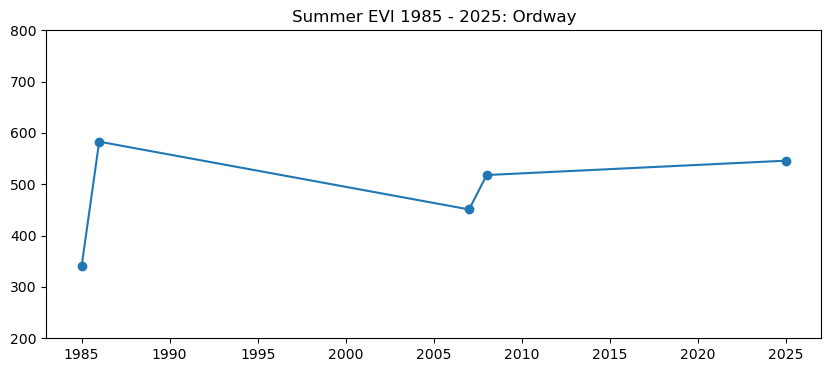

In [187]:
r = 299
c = 0
one = raster_df.query(f"row=={r} & col=={c}").sort_values("year")

fig, ax = plt.subplots(figsize=(10,4))
plt.plot(one['year'],one['vals'], marker='o')
plt.title('Summer EVI 1985 - 2025: Ordway')
ax.set_ylim(200,800)

In [ ]:
# create raster with unique ID per cell (id_grid)
# vectorize id_grid raster (id_grid_gdf)

# join tree polygons to health data
# spatial join tree polygons to id_grid_gdf (overlaps)

# group id_grid_gdf by cell_id:
# within each group calculate intersection of each tree polygon and grid cell, and intersection.area/grid_cell.area

# for each cell find total overlap
# rasterize with proportion as burn-in value

# then you have rasterized proportion beech crown
# and gdf with individual crown coverage per cell - can see which trees were healthy/unhealthy

# use id_grid raster to extract spectral signals






from shapely.geometry import Polygon

def overlap_percentage(outer_polygon, inner_polygon):
    """Calculates the percentage of a polygon that overlaps with another polygon."""

    outer_polygon = Polygon(outer_polygon)
    inner_polygon = Polygon(inner_polygon)

    ratio = outer_polygon.intersection(inner_polygon).area / inner_polygon.area
    return round(ratio * 100, 2)

outer_poly = [(0, 0), (0, 2), (2, 2), (2, 0)]
inner_poly = [(1, 1), (1, 3), (3, 3), (3, 1)]
print(overlap_percentage(outer_poly, inner_poly))



In [13]:
bc.head()

,crownID,name,pubCrowns,StemTag,notes,crwnStatus,GlobalID,poly_type,geometry
0,0,None,None,"271375, 271376","ERS, in office",finished,29bd22b7-3f88-4928-970d-b5c4b94475c4,digitized,"MULTIPOLYGON (((239412.321 4714581.967, 239409..."
1,0,None,None,281378,"ERS, in office",finished,26330696-7cf3-44c4-94c8-42a7cb4b6f6d,digitized,"MULTIPOLYGON (((239439.33 4714569.373, 239439...."
2,0,None,None,281302,"ERS, in office",finished,f9157d44-c8f5-495a-adf8-63ff69486f25,digitized,"MULTIPOLYGON (((239436.085 4714569.244, 239435..."
3,0,None,None,281374,"ERS, in office",finished,d69b2689-6bd0-43f5-9322-a1492f13a1e2,digitized,"MULTIPOLYGON (((239436.031 4714578.651, 239435..."
4,0,None,None,311357,"ERS, in field",finished,61baa801-7840-4cb7-b0cd-0c4cc459d97c,digitized,"MULTIPOLYGON (((239496.635 4714429.981, 239499..."


In [11]:
t.band.values

array(['year_vert_1', 'year_vert_2', 'year_vert_3', 'year_vert_4',
       'year_vert_5', 'year_vert_6', 'year_vert_7', 'src_vert_1',
       'src_vert_2', 'src_vert_3', 'src_vert_4', 'src_vert_5',
       'src_vert_6', 'src_vert_7', 'fit_vert_1', 'fit_vert_2',
       'fit_vert_3', 'fit_vert_4', 'fit_vert_5', 'fit_vert_6',
       'fit_vert_7'], dtype='<U11')

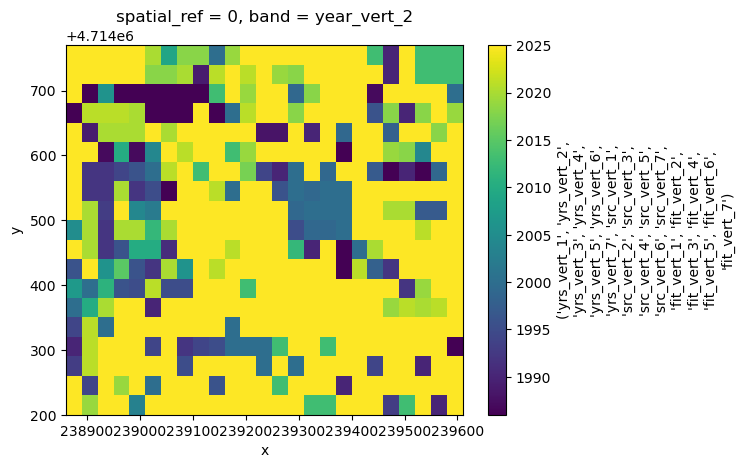

In [138]:
t.sel(band='year_vert_2').plot()